# Reboot - SQL Advanced

Tonight we will work with the `blog.sqlite` database is available at this URL:  
`https://wagon-public-datasets.s3.amazonaws.com/sql_databases/blog.sqlite`

In [ ]:
# $DELETE_BEGIN
! curl https://wagon-public-datasets.s3.amazonaws.com/sql_databases/blog.sqlite > data/blog.sqlite
# $DELETE_END

Let's have a look at our directory structure

In [ ]:
!tree

.
├── README.md
├── data
│   └── blog.sqlite
└── recap.ipynb

1 directory, 3 files


## 1. Schema ERD

❓ Open the `data/blog.sqlite` in DBeaver, explore the schema and draw it on [kitt.lewagon.com/db](https://kitt.lewagon.com/db).

_TODO: Double click this cell and **paste** a screenshot of the schema for future reference_.

_TODO: Double click this cell and **paste** a screenshot of the schema for future reference_.
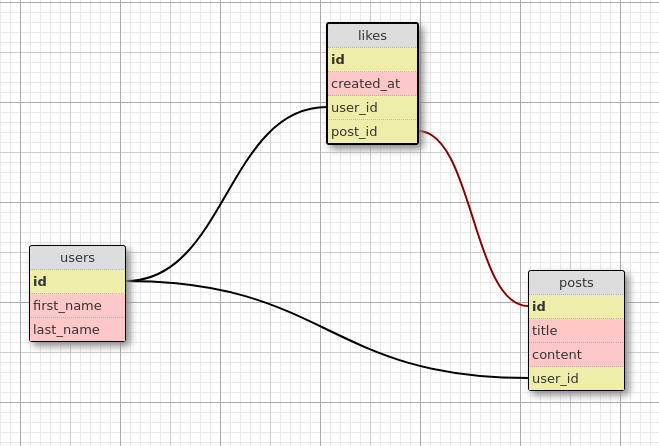

---
## 2. Most liked posts

Complete the code to get **the 3 most liked posts**:

In [ ]:
import sqlite3

conn = sqlite3.connect("data/blog.sqlite")
c = conn.cursor()

# TODO: write the query
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT
        posts.id,
        posts.title,
        COUNT(*) like_count
    FROM posts
    JOIN likes ON posts.id = likes.post_id
    GROUP BY posts.id
    ORDER BY like_count DESC
    LIMIT 3
"""
# $DELETE_END
# TODO: Execute the query
# $DELETE_BEGIN
c.execute(query)
# $DELETE_END
# TODO: Fetch and print the results
# $DELETE_BEGIN
c.fetchall()
# $DELETE_END

[(143, 'Half imagine another.', 84),
 (83, 'Side foot leader popular.', 82),
 (99, 'Area paper whatever mean.', 81)]

---

### Pretty Print using _pandas_

The readbility of our `print()` statements is not so good.

Next week, we will introduce [pandas](https://pandas.pydata.org/) which will vastly improve the UX of our data exploration in Notebooks.

Execute the following cell to load `pandas` library:

In [ ]:
import pandas as pd

Then try the previous `query` again, delegating the job of fetching results + displaying them to the `read_sql_query` function of `pandas`:

In [ ]:
pd.read_sql_query(query, conn)

,id,title,like_count
0,143,Half imagine another.,84
1,83,Side foot leader popular.,82
2,99,Area paper whatever mean.,81


---
## 3. Find the three users who 'liked' the most

In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT
        users.id,
        users.first_name || " " || users.last_name full_name,
        COUNT(*) like_count
    FROM users
    JOIN likes ON users.id = likes.user_id
    GROUP BY users.id 
    ORDER BY like_count DESC
    LIMIT 3
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,id,full_name,like_count
0,43,Michael Allen,236
1,12,Donna Ramirez,233
2,15,Barbara Hurst,227


---
## 4. Find the most liked author

In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT
        users.id,
        users.first_name || " " || users.last_name full_name,
        COUNT(*) like_count
    FROM users
    JOIN posts ON users.id = posts.user_id 
    JOIN likes ON posts.id = likes.post_id
    GROUP BY users.id 
    ORDER BY like_count DESC 
    LIMIT 1
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,id,full_name,like_count
0,57,Teresa Moore,647


---
## 5. Who are the authors of the 3 most liked posts?

In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT
        users.first_name || " " || users.last_name author_full_name,
        COUNT(*) like_count
    FROM posts
    JOIN likes ON posts.id = likes.post_id
    JOIN users ON posts.user_id = users.id
    GROUP BY posts.id 
    ORDER BY like_count DESC
    LIMIT 3
"""

# Other solution: reuse the query for question 2
query = """
    WITH three_most_liked_posts AS (
        SELECT
            posts.id,
            posts.title,
            COUNT(*) like_count,
            posts.user_id
        FROM posts
        JOIN likes ON posts.id = likes.post_id
        GROUP BY posts.id
        ORDER BY like_count DESC
        LIMIT 3
    )
    SELECT
        users.first_name || " " || users.last_name author_full_name,
        like_count
    FROM three_most_liked_posts
    JOIN users ON three_most_liked_posts.user_id = users.id
    
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,author_full_name,like_count
0,Melissa Henry,84
1,Cynthia Raymond,82
2,Alexander Cook,81


---
## 6. How many people liked at least one post?

In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT COUNT(DISTINCT user_id) AS liker_count
    FROM likes
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,liker_count
0,49


---
## 7. Compute the cumulative number of likes per day

In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    SELECT
        created_at date,
        COUNT(*) daily_like_count,
        SUM(COUNT(*)) OVER(
            ORDER BY created_at
        ) cumulative_daily_like_count
    FROM likes
    GROUP BY created_at
"""

# Other solution: first compute the daily like count
# Then compute the cumulative sum of this column
query = """
    WITH daily_likes AS (
        SELECT
            created_at,
            COUNT(*) daily_like_count
        FROM likes
        GROUP BY created_at
    )
    SELECT
        created_at date,
        SUM(daily_like_count) OVER(ORDER BY created_at) cumulative_daily_like_count
    FROM daily_likes;
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,date,cumulative_daily_like_count
0,2019-01-01,24
1,2019-01-02,58
2,2019-01-03,98
3,2019-01-04,134
4,2019-01-05,161
...,...,...
331,2019-12-24,9882
332,2019-12-25,9915
333,2019-12-26,9947
334,2019-12-27,9970


---
## 8. (Optional) Who's the biggest fan of each author?

The biggest fan of an author is defined as the user who liked the most the author's posts.
<br><br>
<details>
    <summary>💡 Click for Hint</summary>
    You might need to use <code>WITH</code>
</details>


In [ ]:
query = """

"""
# $DELETE_BEGIN
query = """
    WITH liker_per_author AS (
        SELECT
            posts.user_id author_id,
            likes.user_id liker_id,
            COUNT(*) like_count
        FROM likes
        JOIN posts ON likes.post_id = posts.id
        GROUP BY author_id, liker_id
        ORDER BY author_id, like_count DESC
    )
    SELECT
        authors.first_name || " " || authors.last_name author_full_name,
        likers.first_name || " " || likers.last_name biggest_fan_full_name,
        like_count
    FROM liker_per_author
    JOIN users authors ON liker_per_author.author_id = authors.id
    JOIN users likers ON liker_per_author.liker_id = likers.id
    GROUP BY authors.id
    ORDER BY author_full_name
"""
# $DELETE_END
pd.read_sql_query(query, conn)

,author_full_name,biggest_fan_full_name,like_count
0,Alexander Cook,Jeremiah Ruiz,20
1,Brenda Griffin,Michael Allen,12
2,Brett Johnston,Tristan Kelley,19
3,Brittany Miller,Barbara Hurst,16
4,Cynthia Raymond,Donald Gray,24
5,David Boyd,Barbara Hurst,18
6,Donna Smith,Karen Brown,20
7,Eric Carroll,James Payne,18
8,Erin Smith,Lisa Norris,7
9,Grace Kerr,Ashley Brooks,19
